<a href="https://colab.research.google.com/github/seunghokimS/DACON-Agricultural-product-price-prediction-/blob/main/%EB%86%8D%EC%82%B0%EB%AC%BC_%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1(autogluon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autogluon

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor
from autogluon.tabular import TabularDataset
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import autogluon.timeseries as agts
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/temp_train(11.16) (1).csv")
test = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/df_test.csv")
sub_df = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/sample_submission.csv")

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
df_train = df_train.drop(columns = ['timestamp(M)','수출 중량','수출 금액','수입 중량','수입 금액','무역수지'])

In [ ]:
df_train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),holiday,year,month,day
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,Y,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,N,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,N,2019,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,N,2019,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,N,2019,1,5
...,...,...,...,...,...,...,...,...,...,...,...
59392,CB_E_J_20230302,2023-03-02,CB,E,J,0.0,0.0,N,2023,3,2
59393,CB_E_J_20230303,2023-03-03,CB,E,J,0.0,0.0,N,2023,3,3
59394,CB_F_J_20230301,2023-03-01,CB,F,J,0.0,621.0,Y,2023,3,1
59395,CB_F_J_20230302,2023-03-02,CB,F,J,238992.0,653.0,N,2023,3,2


# 파생변수 생성

In [ ]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_train['week_of_year'] = df_train['timestamp'].dt.year * 100 + df_train['timestamp'].dt.week
df_test['week_of_year'] = df_test['timestamp'].dt.year * 100 + df_test['timestamp'].dt.week

<ipython-input-8-667e504779dc>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['week_of_year'] = df_train['timestamp'].dt.year * 100 + df_train['timestamp'].dt.week
<ipython-input-8-667e504779dc>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test['week_of_year'] = df_test['timestamp'].dt.year * 100 + df_test['timestamp'].dt.week


In [ ]:
# from sklearn import preprocessing

# # preprocessing.MinMaxScaler()
# # preprocessing.StandardScaler()
# # preprocessing.RobustScaler()
# # preprocessing.Normalizer()

# # 1. 스케일러를 선택 후 스케일러 객체를 지정한다
# scaler = preprocessing.MinMaxScaler()

# # 2. 스케일러 객체의 fit()함수를 이용하여 필요한 파라미터를 저장한다
# # scaler_fit에는 칼럼별 최대와 최소값이 저장되어있다.
# scaler_fit = scaler.fit(X)

# # 3. 스케일러 객체의 transform()함수를 이용하여 스케일링을 수행한다
# result=scaler_fit.transform(X)

# inverse_scaled_data = scaler.inverse_transform(scaled_data)

In [ ]:
col = ['supply(kg)', 'price(원/kg)']

scaler = MinMaxScaler()
scaler_fit = scaler.fit(df_train[col])
result = scaler_fit.transform(df_train[col])
df_train[col] = result

In [ ]:
col = ['item','corporation', 'location','holiday']

for i in col:
  encoder = LabelEncoder()
  df_train[i] = encoder.fit_transform(df_train[i])
  df_test[i] = encoder.transform(df_test[i])
  # test fit은 Data leakage


In [ ]:
df_train = TabularDataset(df_train)
df_test = TabularDataset(df_test)

In [ ]:
df_train = df_train.drop(columns=['timestamp','ID'], axis =1)
df_test = df_test.drop(columns=['timestamp','ID'], axis =1)
# X, y = df_train.drop(['price(원/kg)'], axis=1) , df_train[['price(원/kg)']]
# X_train, X_vaild, y_train, y_vaild = train_test_split(X, y, test_size=0.2)

In [ ]:
df_train.drop(columns = ['supply(kg)'], axis = 1 )

,item,corporation,location,price(원/kg),holiday,year,month,day,week_of_year
0,4,0,0,0.000000,1,2019,1,1,201901
1,4,0,0,0.000000,0,2019,1,2,201901
2,4,0,0,0.139993,0,2019,1,3,201901
3,4,0,0,0.114068,0,2019,1,4,201901
4,4,0,0,0.101268,0,2019,1,5,201901
...,...,...,...,...,...,...,...,...,...
59392,1,4,0,0.000000,0,2023,3,2,202309
59393,1,4,0,0.000000,0,2023,3,3,202309
59394,1,5,0,0.050310,1,2023,3,1,202309
59395,1,5,0,0.052902,0,2023,3,2,202309


In [ ]:
df_train = df_train.drop(columns = ['supply(kg)'], axis = 1 )

In [ ]:
predictor = TabularPredictor(label='price(원/kg)',
                             eval_metric='rmse',
                             problem_type= 'regression')

predictor.fit(train_data = df_train,
              presets='best_quality',
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 5, num_bag_sets = 1, num_stack_levels = 1,
              verbosity = 2
              )
ld_board = predictor.leaderboard(df_train, silent=True)
pred_y = predictor.predict(df_test)
pred_y


No path specified. Models will be saved in: "AutogluonModels/ag-20231119_134226/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231119_134226/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   75.37 GB / 115.66 GB (65.2%)
Train Data Rows:    59397
Train Data Columns: 8
Label Column: price(원/kg)
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11057.48 MB
	Train Data (Original)  Memory Usage: 3.8 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitti

0       0.298209
1       0.241904
2       0.253108
3       0.301809
4       0.301432
          ...   
1087    0.041471
1088    0.041530
1089    0.032194
1090    0.045683
1091    0.048571
Name: price(원/kg), Length: 1092, dtype: float32

# parameter

- train_data = df_train: 훈련 데이터셋입니다.
- presets='best_quality': 예측 정확도를 우선시하는 최상의 품질 설정을 사용합니다.
- auto_stack = True: 성능을 향상시키기 위해 자동으로 모델 스태킹을 수행합니다.
- fit_weighted_ensemble = True: 모든 모델의 가중 앙상블을 학습하여 예측 성능을 향상시킵니다.
- num_bag_folds = 10: 과적합을 줄이는 데 도움이 되는 10겹의 배깅을 사용합니다.
- num_bag_sets = 30: 성능을 안정화하기 위해 배깅을 30회 반복합니다.
- num_stack_levels = 3: 이전 레벨의 모델을 기반으로 새로운 모델을 구축하는 3개의 스태킹 레벨을 만듭니다.
- num_gpus = 1: 모델 훈련을 위해 GPU 한 개를 사용합니다(사용 가능한 경우).
- num_cpus = 24: 훈련을 위해 CPU 코어 24개를 활용합니다.
- verbosity = 2: 훈련 과정 중 상세한 로그를 출력합니다.

In [ ]:
min = np.min(df_train['price(원/kg)'])
max = np.max(df_train['price(원/kg)'])
print(min, max)

0.0 12343.500000000004


In [ ]:
original_data_recovered = (pred_y) * (max - min) + (min)

In [ ]:
original_data_recovered = round(original_data_recovered , 2)

In [ ]:
original_data_recovered

0       3680.939941
1       2985.939941
2       3124.239990
3       3725.379883
4       3720.729980
           ...     
1087     511.890015
1088     512.619995
1089     397.380005
1090     563.890015
1091     599.539978
Name: price(원/kg), Length: 1092, dtype: float32

In [ ]:
ld_board = predictor.leaderboard(df_train, silent=True)
ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE_BAG_L1,-0.032469,-0.087953,13.499224,2.011513,40.247349,13.499224,2.011513,40.247349,1,True,5
1,ExtraTreesMSE_BAG_L1,-0.035017,-0.093105,10.978216,2.547287,19.629387,10.978216,2.547287,19.629387,1,True,7
2,NeuralNetTorch_BAG_L2,-0.044763,-0.068022,494.666079,199.151796,4179.307419,3.103428,0.919596,599.120942,2,True,20
3,NeuralNetFastAI_BAG_L2,-0.046867,-0.065722,498.883281,199.869366,4090.590860,7.320629,1.637166,510.404383,2,True,18
4,LightGBMLarge_BAG_L1,-0.047496,-0.075429,109.228716,39.116641,113.503187,109.228716,39.116641,113.503187,1,True,11
5,WeightedEnsemble_L3,-0.047933,-0.064780,529.016950,209.764385,4839.601078,0.012830,0.001794,1.550788,3,True,22
6,LightGBMXT_BAG_L2,-0.048001,-0.065749,507.023675,202.697756,3622.365349,15.461024,4.465556,42.178872,2,True,13
7,LightGBM_BAG_L2,-0.050100,-0.066308,494.031794,199.306329,3604.647167,2.469142,1.074130,24.460690,2,True,14
8,XGBoost_BAG_L2,-0.050156,-0.066639,493.340121,198.967723,3606.029126,1.777470,0.735523,25.842649,2,True,19
9,CatBoost_BAG_L2,-0.050235,-0.066553,492.168600,198.422307,3665.131318,0.605948,0.190107,84.944841,2,True,16


<Axes: >

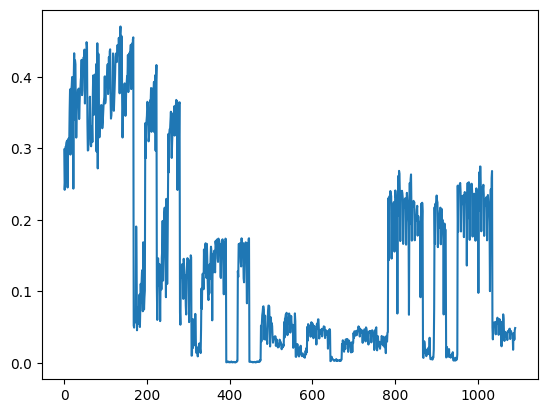

In [ ]:
pred_y.plot()

In [ ]:
from google.colab import files
sub_df['answer'] = original_data_recovered
sub_df.to_csv('sub_df.csv', index = False)
files.download('sub_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>